# Importing libraries and loading dataset

In [ ]:
# Starting from loading the libraries required for analysis
# This was first done step by step with each model and cell but was combined finally to make the file cleaner and shorter
!pip install xgboost
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor


In [ ]:
# Loading data
file_path = 'Monthly_New.csv'
data = pd.read_csv(file_path)

# First few rows
data.head()


,Year,Month,TotalPrimaryEnergyConsumption,TotalPrimaryEnergyProduction,TotalPrimaryEnergyExports,TotalPrimaryEnergyImports,TotalPrimaryEnergyConsumedbytheIndustrialSector,TotalPrimaryEnergyConsumedbytheResidentialSector,PrimaryEnergyStockChange
0,1973,1,7223.87,5404.72,125.78,1173.08,2027.03,1339.27,771.858
1,1973,2,6592.37,5155.12,120.88,1168.01,1841.30,1174.90,390.129
2,1973,3,6521.44,5419.56,139.95,1309.47,1926.41,983.37,-67.640
3,1973,4,5941.73,5160.81,194.19,1085.17,1914.02,715.39,-110.067
4,1973,5,6071.94,5411.25,196.78,1162.80,2076.47,535.91,-305.335


# Checking for any missing values

In [ ]:
missing_values = data.isnull().sum()
missing_values_percentage = (data.isnull().sum() / len(data)) * 100

missing_data_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_values_percentage
})

missing_data_info


,Missing Values,Percentage
Year,0,0.0
Month,0,0.0
TotalPrimaryEnergyConsumption,0,0.0
TotalPrimaryEnergyProduction,0,0.0
TotalPrimaryEnergyExports,0,0.0
TotalPrimaryEnergyImports,0,0.0
TotalPrimaryEnergyConsumedbytheIndustrialSector,0,0.0
TotalPrimaryEnergyConsumedbytheResidentialSector,0,0.0
PrimaryEnergyStockChange,0,0.0


## Converting data into time series format

In [ ]:
# Creating a unique identifier for each year (sequence from 1 to 74) - To use it as a feature while building models
# Combining 'Year' and 'Month' columns into a new 'Date' column which displays time-series format
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'].astype(str), format='%Y-%m')

data['t'] = range(1, len(data) + 1)

print(data.head())
data.info()



   Year  Month  TotalPrimaryEnergyConsumption  TotalPrimaryEnergyProduction  \
0  1973      1                        7223.87                       5404.72   
1  1973      2                        6592.37                       5155.12   
2  1973      3                        6521.44                       5419.56   
3  1973      4                        5941.73                       5160.81   
4  1973      5                        6071.94                       5411.25   

   TotalPrimaryEnergyExports  TotalPrimaryEnergyImports  \
0                     125.78                    1173.08   
1                     120.88                    1168.01   
2                     139.95                    1309.47   
3                     194.19                    1085.17   
4                     196.78                    1162.80   

   TotalPrimaryEnergyConsumedbytheIndustrialSector  \
0                                          2027.03   
1                                          1841.30   
2       

The dataset does not have any missing values, which is excellent for analysis and model training purposes.

# Normalize data and add features to forecast Production

In [ ]:
# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Defining featues and target variable
features = ['TotalPrimaryEnergyConsumption', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyProduction']
scaled_data = scaler.fit_transform(data[features])

# Converting scaled data back to a dataframe
scaled_data_df = pd.DataFrame(scaled_data, columns=features, index=data.index)


# Splitting the data into a training set (1973-2016) and a test set (2017-2022)
train_data = scaled_data_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = scaled_data_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

# Reshaping the data to fit the RNN input shape - keeping it 1 which can be followed across all RNN models
X_train = train_data.values.reshape((train_data.shape[0], 1, train_data.shape[1]))
X_test = test_data.values.reshape((test_data.shape[0], 1, test_data.shape[1]))

# Since we're going to perform one-step-ahead prediction, the target is the same as the input shifted by one time step
y_train = train_data.values[1:]
y_test = test_data.values[1:]

# Trimming the last sample of the training and test input data coz there is no label for it
X_train = X_train[:-1, :, :]
X_test = X_test[:-1, :, :]

# Confirming the shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((527, 1, 5), (527, 5), (71, 1, 5), (71, 5))

In [ ]:
# Defining the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the model
history = model.fit(X_train, y_train, epochs=200, batch_size=42, validation_split=0.2, verbose=1)

# Evaluating the model on test data
test_loss = model.evaluate(X_test, y_test)

# Making Predictions
y_pred = model.predict(X_test)

test_loss


Epoch 1/200
11/11 [==============================] - 2s 31ms/step - loss: 0.1160 - val_loss: 0.1507
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0717 - val_loss: 0.0892
Epoch 3/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0435 - val_loss: 0.0522
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0272 - val_loss: 0.0361
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0352
Epoch 6/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0357
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0361
Epoch 8/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0342
Epoch 9/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0123 - val_loss: 0.0335
Epoch 10/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0320
Epoch 11

0.0605359822511673

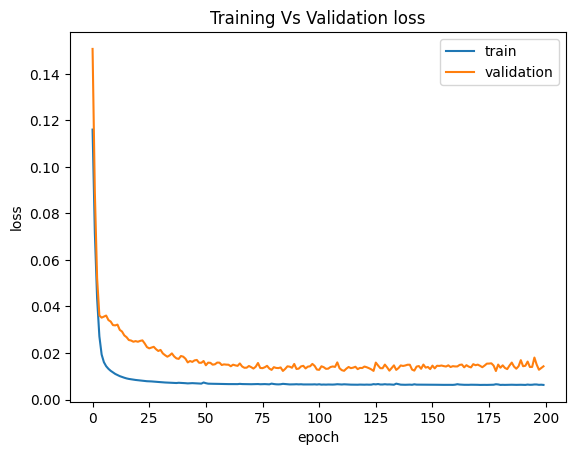

In [ ]:
# Plotting train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Loss Plot Analysis**:

- After hyperparameter tuning, the loss plot indicates a consistent decrease in both validation loss and overall loss as the number of epochs increases.


## Error and performance calculation

In [ ]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Results
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')



Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.26
Mean Absolute Error (MAE): 0.19


**Analysis**:

- The MSE and RMSE values indicate that the model is making accurate predictions, with relatively small errors. The MAE value represents the absolute prediction error.

- Specifically, for the Production test set, the MSE is 0.06, RMSE is 0.26, and MAE is 0.19. These low error values suggest that the RNN model performed well in predicting Total Primary Energy Production.


# Plotting Actual Vs Forecast Total Primary Energy Production

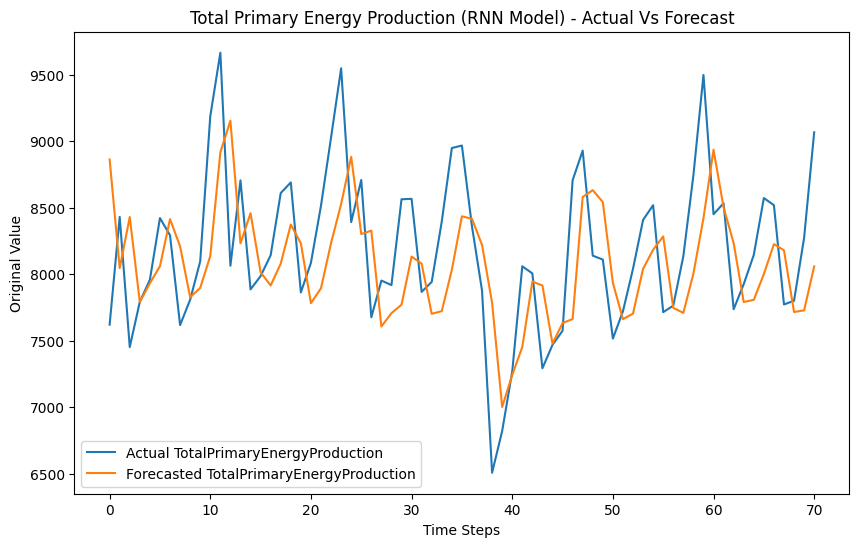

In [ ]:
# Doing Inverse transformation which will help visualize the plot nicely since it allows to plot the values in the original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Plot the actual and forecasted consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label='Actual TotalPrimaryEnergyProduction')
plt.plot(y_pred_actual[:, 0], label='Forecasted TotalPrimaryEnergyProduction')
plt.title('Total Primary Energy Production (RNN Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Original Value')
plt.legend()
plt.show()

**Analysis**:

- The visual comparison between the actual and forecasted plots is promising, indicating that the predictions have low errors and the forecasts are accurate.


# Normalize data and add features to forecast Consumption

In [ ]:
scaler = MinMaxScaler()

features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports','t', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyConsumption']

scaled_features = scaler.fit_transform(data[features])
scaled_target = scaler.fit_transform(data[target])

scaled_data_df = pd.DataFrame(scaled_features, columns=features, index=data.index)
scaled_target_df = pd.DataFrame(scaled_target, columns=target, index=data.index)

train_data = scaled_data_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = scaled_data_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

y_train = scaled_target_df[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
y_test = scaled_target_df[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

X_train = train_data.values.reshape((train_data.shape[0], 1, train_data.shape[1]))
X_test = test_data.values.reshape((test_data.shape[0], 1, test_data.shape[1]))


X_train = X_train[:-1, :, :]
y_train = y_train[:-1]
X_test = X_test[:-1, :, :]
y_test = y_test[:-1]


X_train.shape, y_train.shape, X_test.shape, y_test.shape


((527, 1, 5), (527, 1), (71, 1, 5), (71, 1))

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=200, batch_size=42, validation_split=0.2, verbose=1)

test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

test_loss

Epoch 1/200
11/11 [==============================] - 1s 28ms/step - loss: 0.2188 - val_loss: 0.2418
Epoch 2/200
11/11 [==============================] - 0s 5ms/step - loss: 0.1129 - val_loss: 0.0885
Epoch 3/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0217
Epoch 4/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0299 - val_loss: 0.0104
Epoch 5/200
11/11 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0115
Epoch 6/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0217 - val_loss: 0.0111
Epoch 7/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0189 - val_loss: 0.0102
Epoch 8/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0168 - val_loss: 0.0097
Epoch 9/200
11/11 [==============================] - 0s 5ms/step - loss: 0.0151 - val_loss: 0.0090
Epoch 10/200
11/11 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0082
Epoch 11

0.006062972825020552

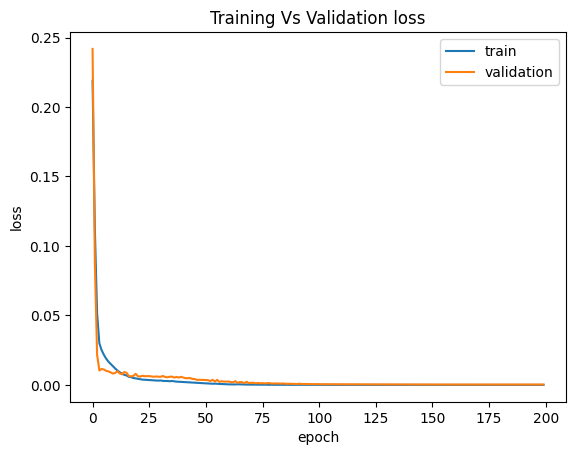

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Loss Plot Analysis**:

- After hyperparameter tuning, the loss plot shows a consistent decrease in both validation loss and overall loss as the number of epochs increases.


In [ ]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.08
Mean Absolute Error (MAE): 0.07


**Analysis**:

- For the Consumption test set, the MSE is 0.01, RMSE is 0.08, and MAE is 0.07. These low error values suggest that the RNN model performed well in predicting Total Primary Energy Consumption.

- In summary, the RNN model demonstrated good performance for both Production and Consumption forecasts.


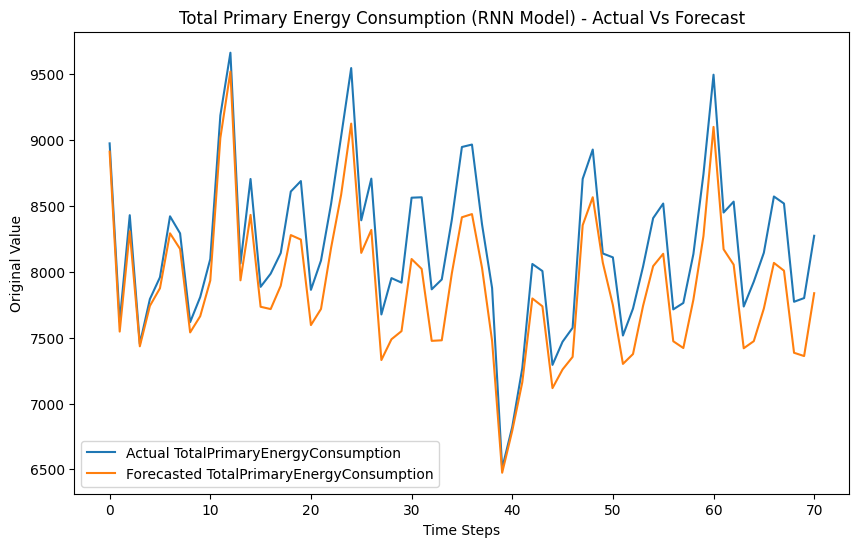

In [ ]:
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)


plt.figure(figsize=(10, 6))
plt.plot(y_test_actual[:, 0], label='Actual TotalPrimaryEnergyConsumption')
plt.plot(y_pred_actual[:, 0], label='Forecasted TotalPrimaryEnergyConsumption')
plt.title('Total Primary Energy Consumption (RNN Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Original Value')
plt.legend()
plt.show()


**Analysis**:

- The visual comparison between the actual and forecasted plots indicates a high level of accuracy, validating that the predictions have low errors, and the forecasts are quite accurate.


## XGBoost model to forecast production

In [ ]:

# Defining featues and target variable
features = [ 'TotalPrimaryEnergyConsumption','TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports', 't', 'PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyProduction']

# Initializing the MinMaxScaler and scaling data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Splitting the data into training (1973-2016) and test (2017-2022) sets
train_data = data[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = data[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

# Defining X_train, y_train, X_test, y_test
X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

# Initializing and fitting an XGBoost model
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb_model.predict(X_test)

# Mean Squared Error (MSE), and Mean Absolute Error (MAE)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Results - Test set
print(f'Mean Squared Error (MSE)- Test Set: {mse:.2f}')
print(f'Mean Absolute Error (MAE) - Test Set: {mae:.2f}')


Mean Squared Error (MSE)- Test Set: 0.06
Mean Absolute Error (MAE) - Test Set: 0.23


**Analysis**:

- For the Production test set, the MSE is 0.06, and MAE is 0.23. These lower error values suggest that the XGBoost model performed well in predicting Total Primary Energy Production.


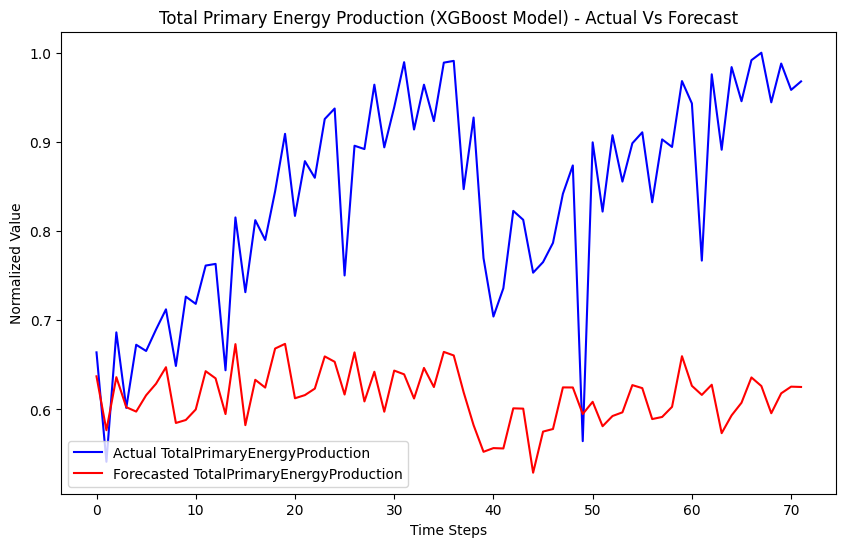

In [ ]:
# Plotting the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual TotalPrimaryEnergyProduction', color='blue')
plt.plot(y_pred, label='Forecasted TotalPrimaryEnergyProduction', color='red')
plt.title('Total Primary Energy Production (XGBoost Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()


**Analysis**:

- The comparison between the actual and forecasted plots is not very accurate, suggesting the presence of overfitting in the model.
.

## Xboost model to forecast Consumption

In [ ]:

features = ['TotalPrimaryEnergyProduction', 'TotalPrimaryEnergyExports', 'TotalPrimaryEnergyImports','t','PrimaryEnergyStockChange']
target = ['TotalPrimaryEnergyConsumption']

scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

train_data = data[(data['Year'] >= 1973) & (data['Year'] <= 2016)]
test_data = data[(data['Year'] >= 2017) & (data['Year'] <= 2022)]

X_train = train_data[features].values
y_train = train_data[target].values
X_test = test_data[features].values
y_test = test_data[target].values

xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)



mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')


Mean Squared Error (MSE): 0.01
Mean Absolute Error (MAE): 0.08


**Analysis**:

- For the Consumption test set, the MSE is 0.01, and MAE is 0.08. These lower error values indicate that the XGBoost model performed well in predicting Total Primary Energy Consumption.

- In summary, the XGBoost model demonstrated good performance for both Production and Consumption forecasts.


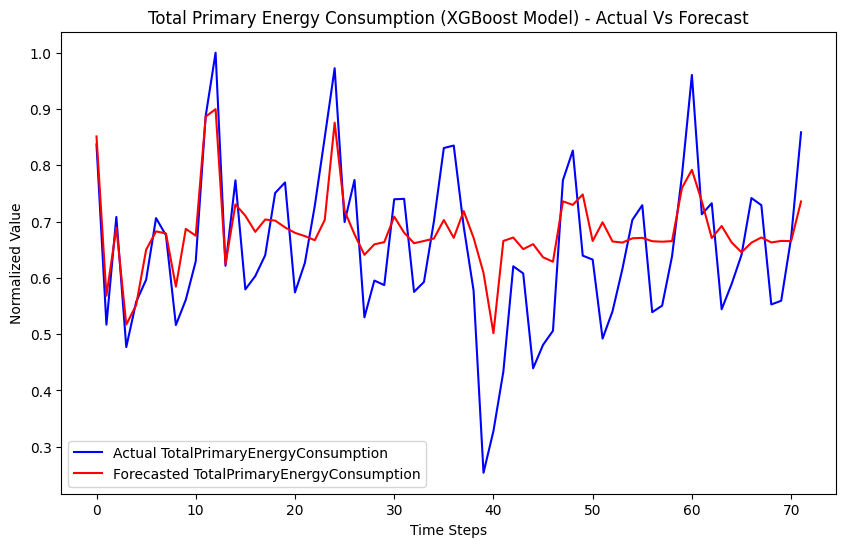

In [ ]:
# Plot the actual and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual TotalPrimaryEnergyConsumption', color='blue')
plt.plot(y_pred, label='Forecasted TotalPrimaryEnergyConsumption', color='red')
plt.title('Total Primary Energy Consumption (XGBoost Model) - Actual Vs Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

**Analysis**:

- The comparison between the actual and forecasted plots suggests that the model has some overfitting issues.

- Overall, when considering both the evaluation metrics and the visual representation of forecasted and actual values, it appears that the RNN model outperformed the XGBoost method for both Production and Consumption forecasts, despite the similar error rates.
